# Выполнение SQL запросов в Python

Так как хранить параметры учётной записи в коде небезопасно, создадим хранилище.

Я оставил код для создания хранилища, чтобы его можно было проверить. Если Вы не захотите создавать хранилище, можно взять значения, которые я в него сохранял, и внести в переменные user, password, host, port

In [11]:
!pip install keyring -q

In [25]:
import keyring

# Установка секретов
keyring.set_password("sql_course_database", "user", "student")
keyring.set_password("sql_course_database", "password", "6ecf4d61")
keyring.set_password("sql_course_database", "host", "92.63.70.133")
keyring.set_password("sql_course_database", "port", "5432")

In [2]:
import keyring

# Получение секретов
user = keyring.get_password("sql_course_database", "user")
password = keyring.get_password("sql_course_database", "password")
host = keyring.get_password("sql_course_database", "host")
port = keyring.get_password("sql_course_database", "port")

## 1. Серверный курсор
Вам необходимо построить график зависимости среднего ARPU и 95%-го доверительного интервала для него от количества обработанных строк. В данном задании вы будете работать с серверным курсором.
1) Напишите скрипт, который подключается к базе данных project (схема mobile_game) и поэтапно, с шагом в 300 строк (т.е. по 300 пользователей за один шаг), выгружает данные по ARPU пользователей за 2023-03-01.
2) Для расчетов ARPU используйте объединение данных из таблиц sessions и transactions, чтобы учесть всех пользователей с сессиями, даже если у них не было транзакций (в этом случае их доход будет считаться как 0).
3) Накапливая данные (от 0 до N записей) при каждой новой порции в 300 строк, рассчитывайте и фиксируйте:
    - Средний ARPU
    - 95%-ый доверительный интервал для среднего ARPU
4) Важно! При подсчете ARPU по пользователям за 2023-03-01 отсортируйте строки в случайном порядке (используйте ORDER BY RANDOM() в запросе).

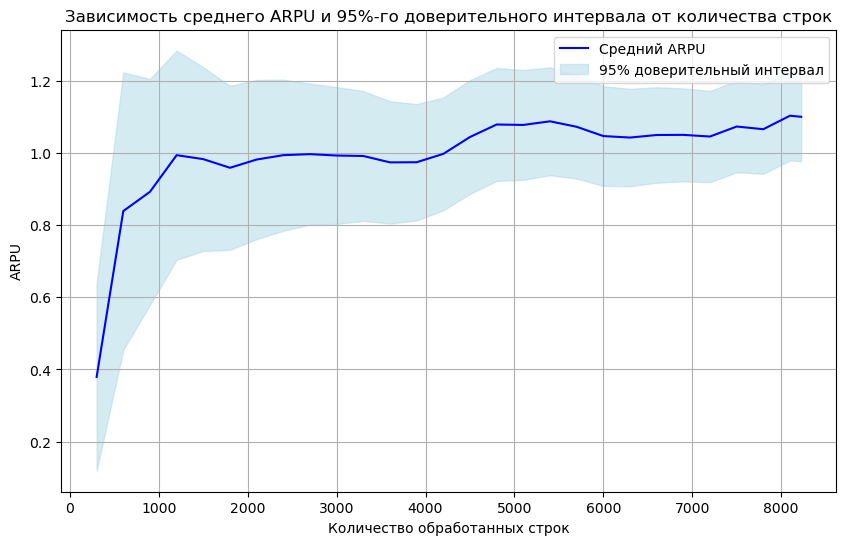

In [7]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Функция для расчета доверительного интервала на основе нормального распределения
def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = np.std(data, ddof=1) / np.sqrt(n)
    margin_of_error = norm.ppf((1 + confidence) / 2) * se
    return mean, mean - margin_of_error, mean + margin_of_error


conn = psycopg2.connect(
    dbname="project",
    user=user,
    password=password,
    host=host,
    port=port
)
cursor = conn.cursor()

query = """
    select 
        s.user_id,
        coalesce(sum(t.revenue), 0)::float as revenue
    from mobile_game.sessions s
    left join  mobile_game.transactions t
        on s.user_id = t.user_id
        and t.event_date = '2023-03-01'
    where 
        s.session_start_time::date = '2023-03-01'
    group by 1
    order by random()
"""


cursor.itersize = 300 
cursor.execute(query)

arpu_data = []
steps = []
means = []
lower_bounds = []
upper_bounds = []

while True:
    rows = cursor.fetchmany(300)
    if not rows:
        break

    arpu_data.extend([row[1] for row in rows])
    steps.append(len(arpu_data))

    if len(arpu_data) > 1:
        mean, lower, upper = calculate_confidence_interval(arpu_data)
        means.append(mean)
        lower_bounds.append(lower)
        upper_bounds.append(upper)
    else:
        # Добавляем начальные значения для первой итерации
        means.append(np.mean(arpu_data))
        lower_bounds.append(np.mean(arpu_data))
        upper_bounds.append(np.mean(arpu_data))

cursor.close()
conn.close()

plt.figure(figsize=(10, 6))
plt.plot(steps, means, label='Средний ARPU', color='blue')
plt.fill_between(steps, lower_bounds, upper_bounds, color='lightblue', alpha=0.5, label='95% доверительный интервал')
plt.xlabel('Количество обработанных строк')
plt.ylabel('ARPU')
plt.title('Зависимость среднего ARPU и 95%-го доверительного интервала от количества строк')
plt.legend()
plt.grid(True)
plt.show()

## 2. Загрузка и обновление данных
Вам нужно написать скрипт, который подключается к базе данных postgres и выполняет следующие шаги: 
1) создает таблицу, необходимую для загрузки CSV файла. Таблица должна называться transactions<фамилияи_о>
2) загружает данные из CSV файла в таблицу, расположенную в схеме table_view_tasks. 
3) Используя SQL-запрос, выгружает данные в pandas dataframe и отображает первые 10 строк 
4) Обновляет с помощью транзакций данные для user_id = 1 меняя значение revenue на 199.99
5) Повторно загружает результаты запроса в pandas dataframe и отображает первые 10 строк
Требования к скрипту: 
- При ошибке транзакция должна быть отменена.
- Скрипт должен сообщать о завершении загрузки данных или о возникновении ошибок.

In [8]:
cursor.close()
conn.close()

In [19]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

conn = psycopg2.connect(
    dbname="postgres",
    user=user,
    password=password,
    host=host,
    port=port
)

TABLE_NAME = 'transactions_fomin_p_a'
DATA = 'data.csv'


try:
    cursor = conn.cursor()

    # 1) создает таблицу, необходимую для загрузки CSV файла. Таблица должна называться transactions<фамилияи_о>
    create_table_query = f"""
        CREATE TABLE IF NOT EXISTS table_view_tasks.{TABLE_NAME} 
        (user_id INT,
         event_date DATE,
         product_id INT,
         revenue FLOAT)
    """
    cursor.execute(create_table_query)
    conn.commit()
    print("Таблица создана или уже существует.")


    # 2) загружает данные из CSV файла в таблицу, расположенную в схеме table_view_tasks. 
    copy_query = f"""COPY table_view_tasks.{TABLE_NAME} (user_id, event_date, product_id, revenue) FROM STDIN CSV HEADER DELIMITER AS ',' """
    
    with open(DATA, 'r') as file:
        cursor.copy_expert(copy_query, file)
    conn.commit()
    print("Данные успешно загружены.")


    # 3) Используя SQL-запрос, выгружает данные в pandas dataframe и отображает первые 10 строк
    select_query = f"SELECT * FROM table_view_tasks.{TABLE_NAME} LIMIT 10"
    df = pd.read_sql(select_query, conn)
    print(df)

    # 4) Обновляет с помощью транзакций данные для user_id = 1 меняя значение revenue на 199.99
    try:
        update_query = f"""UPDATE table_view_tasks.{TABLE_NAME} SET revenue = 199.99 WHERE user_id = 1"""
        cursor.execute(update_query)
        conn.commit()  # Подтверждение транзакции
        print("Обновление revenue для user_id = 1 выполнено")
    except psycopg2.Error as e:
        conn.rollback()
        print(f"Ошибка обновления данных: {e}")
        raise

    # 5) Повторно загружает результаты запроса в pandas dataframe и отображает первые 10 строк
    df = pd.read_sql(select_query, conn)
    print(df)


except psycopg2.Error as e:
    print(f"Ошибка подключения к базе данных или выполнения запроса: {e}")
except Exception as e:
    print(f"Произошла непредвиденная ошибка: {e}")

cursor.close()
conn.close()
print("Подключение к базе данных закрыто.")

Таблица создана или уже существует.
Данные успешно загружены.


C:\Users\pahan\AppData\Local\Temp\ipykernel_14584\2279536037.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(select_query, conn)


   user_id  event_date  product_id  revenue
0        1  2023-03-01         101     9.99
1        2  2023-03-01         102    19.99
2        3  2023-03-01         103    29.99
3        4  2023-03-01         104    39.99
4        5  2023-03-01         105    49.99
5        6  2023-03-01         106    59.99
6        7  2023-03-01         107    69.99
7        8  2023-03-01         108    79.99
8        9  2023-03-01         109    89.99
9       10  2023-03-01         110    99.99
Обновление revenue для user_id = 1 выполнено
   user_id  event_date  product_id  revenue
0        2  2023-03-01         102    19.99
1        3  2023-03-01         103    29.99
2        4  2023-03-01         104    39.99
3        5  2023-03-01         105    49.99
4        6  2023-03-01         106    59.99
5        7  2023-03-01         107    69.99
6        8  2023-03-01         108    79.99
7        9  2023-03-01         109    89.99
8       10  2023-03-01         110    99.99
9        1  2023-03-01         

C:\Users\pahan\AppData\Local\Temp\ipykernel_14584\2279536037.py:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(select_query, conn)


## 3. Транзакции в SQL
Используя созданную вами таблицу из прошлого задания осуществите с ней ряд операций с транзакциями в SQL. Для этого напишите SQL-скрипт, который осуществляет следующие шаги:
1) Уменьшает revenue на 50% для всех записей, где user_id находится в диапазоне от 2 до 4.
2) Устанавливает SAVEPOINT (например, after_discount) после первой операции.
3) Устанавливает revenue = 0 для всех записей, где product_id = 102.
4) Выполните откат до SAVEPOINT after_discount
5) Увеличивает revenue на 5% для user_id = 2.

In [ ]:
-- Начало транзакции
begin;

-- Уменьшаем revenue на 50% для всех записей, где user_id находится в диапазоне от 2 до 4
update table_view_tasks.transactions_fomin_p_a
set revenue = revenue * 0.5
where user_id between 2 and 4;

-- Устанавливаем savepoint после первой операции
savepoint after_discount;

-- Устанавливаем revenue = 0 для всех записей, где product_id = 102
update table_view_tasks.transactions_fomin_p_a
set revenue = 0
where product_id = 102;

-- Откат до savepoint after_discount
rollback to savepoint after_discount;

-- Увеличиваем revenue на 5% для user_id = 2
update table_view_tasks.transactions_fomin_p_a
set revenue = revenue * 1.05
where user_id = 2;

-- Фиксируем транзакцию
commit;

select * from table_view_tasks.transactions_fomin_p_a;